In [82]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

from docplex.mp.model import Model as CplexModel
import docplex.mp.solution as CplexSol

import gurobipy as gb

## Leitura dos dados

In [83]:
xlsx = pd.ExcelFile('Dados trab PO1.xlsx')
df1 = pd.read_excel(xlsx, 'Pontos Turisticos')
df2 = pd.read_excel(xlsx, 'Recompensa por horario', header=None)
df3 = pd.read_excel(xlsx, 'Custo (reais)', header=None)
df4 = pd.read_excel(xlsx, 'Tempo (min)', header=None)

In [84]:
toy_size = 15
df1 = df1.head(toy_size)
df2 = df2.loc[:toy_size,:]
df3 = df3.loc[:toy_size,:toy_size]
df4 = df4.loc[:toy_size,:toy_size]

In [85]:
df1

,Id,Nome,Custo Fixo,Abre - horario,Fecha - horario,Permanecia,Avaliacao,Preferencia
0,1,Corcovado,82.0,8.0,19.0,2.00,4.5,Tarde
1,2,Mirante Dona Marta,0.0,8.0,17.0,2.00,4.5,Manha
2,3,Pão de Açúcar,104.4,8.0,21.0,2.00,4.5,Tarde
3,4,Forte de Copacabana,6.0,10.0,18.0,1.66,4.5,Tarde
4,5,Praia de Copacabana,0.0,7.0,19.0,3.00,4.5,Manha
5,6,Pedra do Arpoador,0.0,7.0,19.0,1.66,4.5,Tarde
6,7,Praia de Ipanema,0.0,8.0,17.0,3.00,4.5,Manha
7,8,Mirante do Leblon,0.0,7.0,19.0,1.66,4.5,Tarde
8,9,Parque Dois Irmãos,0.0,8.0,22.0,1.66,4.5,Tarde
9,10,Morro Dois Irmãos,0.0,7.0,19.0,3.00,5.0,Manha


In [86]:
startingPoint = 4

df1.at[startingPoint, 'Nome'] = 'Hotel (na praia de Copacabana)'
df1.at[startingPoint,'Abre - horario'] = 9
df1.at[startingPoint,'Fecha - horario'] = 22
df1.at[startingPoint,'Permanecia'] = 0
df1.at[startingPoint,'Custo Fixo'] = 0
df1.at[startingPoint,'Avaliacao'] = 0

In [87]:
CF = np.asarray(df1['Custo Fixo'], dtype=float)       #custo fixo
Ta = np.asarray(df1['Abre - horario'], dtype=float)   #tempo de abertura da janela
Tf = np.asarray(df1['Fecha - horario'], dtype=float)  #tempo de encerramento da janela
Tp = np.asarray(df1['Permanecia'], dtype=float)       #tempo de permanencia em um ponto
RS = np.asarray(df1['Avaliacao'], dtype=float)        #recompensa fixa
RO = np.asarray(df2, dtype=float)                     #recompensa por tempo de chegada
R_max = RS.max() + RO.max()                           #recompensa maxima
C = np.asarray(df3, dtype=float)                      #custo de viagem entre dois pontos
CV_max = C.max()                                      #custo de viagem maximo
CF_max = CF.max()                                     #custo fixo maximo
Td = np.asarray(df4, dtype=float) / 60                #tempo de deslocamento entre dois pontos (em horas)
O = startingPoint                                     #ponto de origem
T_max = float(Tf[O])                                  #horario max de chagada em um ponto
B = 1000000                                           #valor auxiliar
N = len(df1)                                          #quantidade de pontos
D = 3                                                 #quantidade de dias para visita
K = len(df2.columns)                                  #quantidade de janelas de tempo para recompensa (tabela RO)
C_limit = 200                                         #limite de custo

## Plot do grafo baseado no custo e no tempo

### Custo de viagem

In [88]:
G = nx.from_numpy_matrix(C)
pos = nx.spring_layout(G)
pos_c = nx.kamada_kawai_layout(G, dist=C)

In [89]:
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
}
#nx.draw(G, pos=pos, **options)

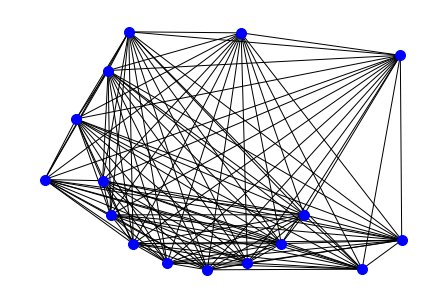

In [90]:
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
}
nx.draw(G, pos=pos_c, **options)

### Tempo de viagem

In [91]:
G2 = nx.from_numpy_matrix(Td)
pos = nx.spring_layout(G2)
pos_t = nx.kamada_kawai_layout(G2, dist=Td * 60)

In [92]:
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
}
#nx.draw(G2, pos=pos, **options)

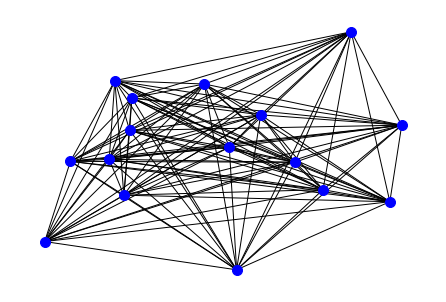

In [93]:
options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
}
nx.draw(G2, pos=pos_t, **options)

## Modelagem

### Parâmetros

$Ta_i$: Tempo de abertura para visitar $i$

$Tf_i$: Tempo de encerramento para visita $i$ 

$Tp_i$: Tempo de permanência na visita de $i$ 

$Td_{i,j}$: Tempo de deslocamento entre $i$ e $j$

$T_{max}$: Tempo máximo para voltar a origem 

$RS_i$: Recompensa fixa por visitar $i$

$RO_{i,k}$: Recompensa por visitar $i$ na janela $k$ (entre $k$ e $k+1$)

$R_{max}$: Recomensa máxima para normalizar na F.O.

$C_{i,j}$: Custo de deslocamento entre $i$ e $j$

$CV_{max}$: Custo máximo de deslocamento para normalizar na F.O.

$CF_i$: Custo fixo para visitar $i$

$CF_{max}$: Custo fixo máximo para normalizar na F.O.

$O$: Ponto de origem (vértice inicial e final de todos os dias)

$D$: Quantidade de dias

$K$: Quantidade de janelas de tempo para recompensa (dimensão 2 de $RO_{i,k}$) 

$N$: Quantidade de pontos turísticos (incluindo origem)

$Custo_{max}$: Custo máximo para solução (orçamento para todos os dias juntos)

$B$: Valor auxiliar utilizado na formulação

### Variáveis

$x_{i,j} = 
\begin{cases}
    1 & \text{se há o deslocamento do ponto } i \text{ para } j \\
    0 & \text{caso contrário}
\end{cases}$

$y_{i,k} = 
\begin{cases}
    1 & \text{se o turista chaga no ponto } i \text{ entre } k \text{ e } k+1 \\
    0 & \text{caso contrário}
\end{cases}$

$t_i \geq 0 \text{,  momento de chegada no ponto } i $

### Formulação


\begin{align}
Max \quad & \sum_{k \in K} \sum_{i \in N} \left( \frac{RO_{i,k} + RS_i}{R_{max}} \right)y_{i,k} - \sum_{i \in N} \sum_{j \in N : i \neq j} \left( \frac{C_{i,j}}{CV_{max}} + \frac{CF_i}{CF_{max}} \right)x_{i,j} \\
S.A. \quad & x_{i,j} \leq 1, \forall i \in N, j \in N \\
     \quad & \sum_{j \in N} x_{i,j} = \sum_{k \in K} y_{i,k}, \forall i \in N : i \neq O \\
     \quad & \sum_{i \in N} x_{i,j} = \sum_{k \in K} y_{j,k}, \forall j \in N : j \neq O \\
     \quad & \sum_{j \in N} x_{O,j} = D \\
     \quad & \sum_{i \in N} x_{i,O} = D \\
     \quad & \sum_{k \in K} y_{i,k} \leq 1, \forall i \in N \\
     \quad & B - B\sum_{k \in K} y_{i,k} + t_i \geq Ta_i, \forall i \in N \\
     \quad & t_i + Tp_i - B + B\sum_{k \in K}y_{i,k} \leq Tf_i, \forall i \in N \\
     \quad & t_j - t_i - B x_{i,j} \geq -B + Td_{i,j} + Tp_i, \forall i \in N, j \in N : j \neq O \\
     \quad & t_i + Tp_i + Td_{i,O} \leq T_{max}, \forall i \in N \\
     \quad & t_i \leq B\sum_{k \in K}y_{i,k}, \forall i \in N \\
     \quad & t_i < 1 + \sum_{k \in K}k y_{i,k}, \forall i \in N \\
     \quad & t_i \geq \sum_{k \in K}k y_{i,k}, \forall i \in N \\
     \quad & \sum_{j \in N} \sum_{i \in N} C_{i,j}x_{i,j} + \sum_{i \in N} (CF_i \sum_{k \in K} y_{i,k}) \leq Custo_{max}
\end{align}


Interpretações:

- 1: Função objetivo maximiza recompensa pela visita dos pontos turísicos menos o custo

- 2: só podemos ir de $i$ para $j$ no máximo 1 vez

- 3 e 4: se um ponto $i$ é visitado, só temos uma chegada e uma saida de $i$ (um ponto turístico não é visitado mais de 1 vez)

- 5 e 6: com temos D rotas (uma rota por dia para visitas), chegamos e saimos da origem D vezes

- 7: como um ponto só é visitado no máximo uma vez, o tempo de chegada nele só pode ter ocorrido em uma janela de tempo

- 8: o tempo de chegada em um ponto tem que ser após sua abertura

- 9: se um ponto $i$ é visitado, temos que chegar nele no máximo $Tp_i$ (tempo de permanência em $i$) antes de ser fechado

- 10: a diferença de tempo de chegada entre dois pontos visitados consecutivamente é pelo menos o deslocamento entre eles mais a permanência no primeiro

- 11: dado que temos que voltar para origem no máximo em $T_{max}$, o tempo de chegada em um ponto $i$ deve considerar o tempo de permanência em $i$ e o deslocamento para a origem

- 12: se um ponto $i$ não é visitado, colocamos o tempo de chegada em $i$ como 0

- 13 e 14: restrições para determinar a janela de tempo da chegada nos pontos turísticos

- 15: o custo dos deslocamentos mais as entradas nos pontos visitados não pode ser maior que o orçamento disponível

## Implementação

### Gurobi

In [94]:
model = gb.Model("PCTSP_gurobi")

x = model.addVars(N, N, vtype = gb.GRB.BINARY, name='x')
y = model.addVars(N, K, vtype = gb.GRB.BINARY, name ='y')
t = model.addVars(N, vtype = gb.GRB.CONTINUOUS, name ='t')

t[O] = float(Ta[O])
for i in range(N):
    x[i,i] = 0

model.setObjective(gb.quicksum(gb.quicksum(((RO[i,k] + RS[i])/R_max)*y[i,k] for i in range(N) if i != O) for k in range(K)) - gb.quicksum(gb.quicksum((C[i,j]/CV_max + CF[i]/CF_max)*x[i,j] for i in range(N)) for j in range(N)), gb.GRB.MAXIMIZE) 

#model.addConstr(t[O] >= Ta[O])
model.addConstrs(x[i,j] <= 1 for i in range(N) for j in range(N))
model.addConstrs(gb.quicksum(x[i,j] for j in range(N)) == gb.quicksum(y[i,k] for k in range(K)) for i in range(N) if i != O)
model.addConstrs(gb.quicksum(x[i,j] for i in range(N)) == gb.quicksum(y[j,k] for k in range(K)) for j in range(N) if j != O)
model.addConstr(gb.quicksum(x[O,j] for j in range(N)) == D)
model.addConstr(gb.quicksum(x[i,O] for i in range(N)) == D)
model.addConstrs(gb.quicksum(y[i,k] for k in range(K)) <= 1 for i in range(N))
model.addConstrs(t[i] + Tp[i] + Td[i,O] <= T_max for i in range(N) if i != O)
model.addConstrs(B - B*gb.quicksum(y[i,k] for k in range(K)) + t[i] >= Ta[i] for i in range(N))
model.addConstrs(t[i] + Tp[i] - B + B*gb.quicksum(y[i,k] for k in range(K)) <= Tf[i] for i in range(N))
model.addConstrs(t[j] - t[i] - B*x[i,j] >= -B + Td[i,j] + Tp[i] for i in range(N) for j in range(N) if j != O)
model.addConstrs(t[i] <= B*gb.quicksum(y[i,k] for k in range(K)) for i in range(N))
model.addConstrs(t[i] + 0.01 <= gb.quicksum(k*y[i,k] for k in range(K)) + 1 for i in range(N))
model.addConstrs(t[i] >= gb.quicksum(k*y[i,k] for k in range(K)) for i in range(N))
model.addConstr(gb.quicksum(gb.quicksum(C[i,j]*x[i,j] for i in range(N)) for j in range(N)) + gb.quicksum(CF[i]*gb.quicksum(y[i,k] for k in range(K)) for i in range(N)) <= C_limit)

model.Params.timeLimit = 30 # TEMPO DE EXECUÇÃO
# model.Params.MIPGap = 0.1
model.optimize()

Set parameter TimeLimit to value 30
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 570 rows, 600 columns and 4396 nonzeros
Model fingerprint: 0xf19cafb4
Variable types: 15 continuous, 585 integer (585 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+06]
  Objective range  [6e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 273 rows and 236 columns
Presolve time: 0.02s
Presolved: 297 rows, 364 columns, 1847 nonzeros
Variable types: 14 continuous, 350 integer (350 binary)
Found heuristic solution: objective -0.0857908

Root relaxation: objective 8.623441e+00, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    8.62344    0   22   -0.08579    8.62344      -     -   

In [95]:
print("função objetivo:", str(round(model.ObjVal,2)))
print("gap:", model.MIPGap * 100)
print("tempo:", model.Runtime)

for v in model.getVars():
    name = str(v.VarName)
    value = v.getAttr(gb.GRB.Attr.X)
    if value > 0:
        print(name +"="+ str(value))
        
x_sol = np.zeros((N,N))
y_sol = np.zeros((N,K))
t_sol = np.zeros((N))

for i in range(N):
    t_sol[i] = t[O] if i == O else t[i].x
    for j in range(N):
        if i != j:
            x_sol[i][j] = x[i,j].x
    for k in range(K):
        y_sol[i][k] = y[i,k].x

função objetivo: 7.06
gap: 0.0
tempo: 11.446882247924805
x[1,3]=1.0
x[3,5]=1.0
x[4,6]=1.0
x[4,11]=1.0
x[4,13]=1.0
x[5,4]=1.0
x[6,9]=1.0
x[7,4]=1.0
x[8,7]=1.0
x[9,8]=1.0
x[10,4]=1.0
x[11,1]=1.0
x[12,10]=1.0
x[13,12]=1.0
y[1,11]=1.0
y[3,14]=1.0
y[4,9]=1.0
y[5,15]=1.0
y[6,9]=1.0
y[7,17]=1.0
y[8,15]=1.0
y[9,12]=1.0
y[10,16]=1.0
y[11,9]=1.0
y[12,13]=1.0
y[13,9]=1.0
t[1]=11.316666666612335
t[3]=14.279999999965847
t[5]=15.989999999999997
t[6]=9.150000000023283
t[7]=17.226666666716337
t[8]=15.46666666668995
t[9]=12.34999999993791
t[10]=16.51666666675205
t[11]=9.099999999976715
t[12]=13.433333333387672
t[13]=9.349999999976715


In [96]:
edges = []

for i in range(N):
    for j in range(N):
        if i != j and x_sol[i][j] > 0:
            edges.append((i,j))
                
print("Arestas:", edges)

vertices = []
arestas = edges.copy()
rotas = []
vertices_rotas = []
for d in range(D):
    rota = []
    v = startingPoint
    v_rota = [v]
    while len(rota) == 0 or v != startingPoint:
        for e in arestas:
            if e[0] == v:
                rota.append(e)
                arestas.remove(e)
                v = e[1]
                if v != startingPoint:
                    vertices.append(v)
                    v_rota.append(v)
                break
    rotas.append(rota)
    vertices_rotas.append(v_rota)
                
print("Vertices:", vertices)

cost = 0
for v in vertices:
    cost += CF[v]
for e in edges:
    cost += C[e]
#print("Custo total:", cost)
            
#rotas

Arestas: [(1, 3), (3, 5), (4, 6), (4, 11), (4, 13), (5, 4), (6, 9), (7, 4), (8, 7), (9, 8), (10, 4), (11, 1), (12, 10), (13, 12)]
Vertices: [6, 9, 8, 7, 11, 1, 3, 5, 13, 12, 10]


In [97]:
for d in range(D):
    locais = [df1.at[v, 'Nome'] for v in vertices_rotas[d]]
    tempos = [round(t[O] if v == O else t_sol[v], 2) for v in vertices_rotas[d]]
    preferencias = [df1.at[v, 'Preferencia'] for v in vertices_rotas[d]]
    permanencias = [df1.at[v, 'Permanecia'] for v in vertices_rotas[d]]
    deslocamento = [round(Td[e],2) for e in rotas[d]]
    custo_entrada = [df1.at[v, 'Custo Fixo'] for v in vertices_rotas[d]]
    
    #df = pd.DataFrame({'Tempo': tempos, 'Nome': locais, 'Vertice': vertices_rotas[d]})
    df = pd.DataFrame({'Tempo': tempos, 'Nome': locais, 'Vertice': vertices_rotas[d], 'Permanencia': permanencias, 'Deslocamento': deslocamento, 'Preferencia': preferencias, 'Custo Entrada': custo_entrada})
    print('DIA', d+1)
    print(df.to_string(index=True))
    print()

print("Custo total:", round(cost, 2))

DIA 1
   Tempo                            Nome  Vertice  Permanencia  Deslocamento Preferencia  Custo Entrada
0   9.00  Hotel (na praia de Copacabana)        4         0.00          0.15       Manha            0.0
1   9.15                Praia de Ipanema        6         3.00          0.20       Manha            0.0
2  12.35               Morro Dois Irmãos        9         3.00          0.12       Manha            0.0
3  15.47              Parque Dois Irmãos        8         1.66          0.10       Tarde            0.0
4  17.23               Mirante do Leblon        7         1.66          0.23       Tarde            0.0

DIA 2
   Tempo                            Nome  Vertice  Permanencia  Deslocamento Preferencia  Custo Entrada
0   9.00  Hotel (na praia de Copacabana)        4         0.00          0.10       Manha            0.0
1   9.10             Parque da Catacumba       11         2.00          0.22       Manha            0.0
2  11.32              Mirante Dona Marta        1  

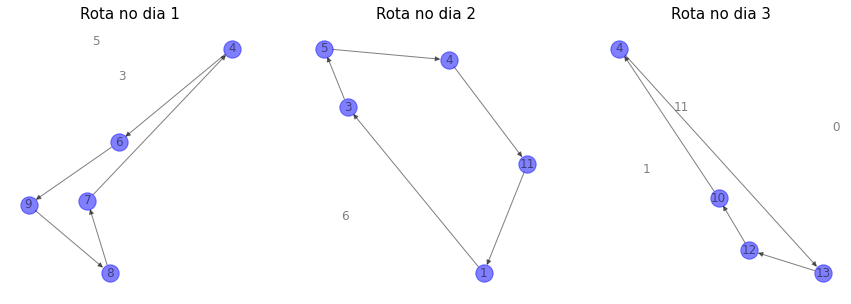

In [98]:
options = {
    'node_color': 'blue',
    'node_size': 300,
    'alpha': 0.5,
    'width': 1,
}

f = plt.figure(figsize=(15,5))
for d in range(D):
    subax = f.add_subplot(1, D, d+1)
    subax.set_title('Rota no dia '+str(d+1), fontsize=15)
    nx.draw(G, pos=pos_t, nodelist=vertices_rotas[d], edgelist=rotas[d], with_labels=True, arrows=True, ax=subax, **options)
    
#FALTA COLOCAR O MAPA DE FUNDO E OS PONTOS NAS COORDENADAS ESPECIFICAS

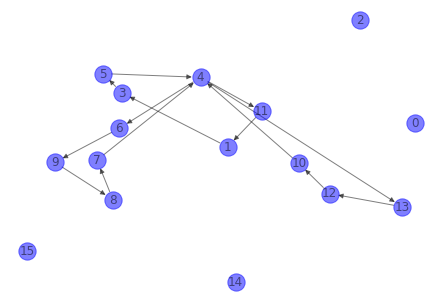

In [99]:
options = {
    'node_color': 'blue',
    'node_size': 300,
    'alpha': 0.5,
    'width': 1,
}

nx.draw(G, pos=pos_t, edgelist=edges, with_labels=True, arrows=True, **options)

### Cplex

In [100]:
v_x = [(i,j) for i in range(N) for j in range(N)]
v_y = [(i,k) for i in range(N) for k in range(K)]
v_t = [i for i in range(N)]

mdl = CplexModel('PCTSP_cplex')

x = mdl.binary_var_dict(v_x, name='x')
y = mdl.binary_var_dict(v_y, name='y')
t = mdl.continuous_var_dict(v_t, name='t')

t[O] = Ta[O]
for i in range(N):
    x[i,i] = 0

mdl.maximize(mdl.sum(mdl.sum(((RO[i,k] + RS[i])/R_max)*y[(i,k)] for i in range(N) if i != O) for k in range(K)) - mdl.sum(mdl.sum((C[i,j]/CV_max + CF[i]/CF_max)*x[(i,j)] for i in range(N)) for j in range(N)))

for i in range(N):
    for j in range(N):
        mdl.add_constraint(x[(i,j)] <= 1)
        
        if j != O:
            mdl.add_constraint(t[j] - t[i] - B*x[(i,j)] >= -B + Td[i,j] + Tp[i])
    
for i in range(N):
    mdl.add_constraint(mdl.sum(y[(i,k)] for k in range(K)) <= 1)
    mdl.add_constraint(B - B*mdl.sum(y[(i,k)] for k in range(K)) + t[i] >= Ta[i])
    mdl.add_constraint(t[i] + Tp[i] - B + B*mdl.sum(y[(i,k)] for k in range(K)) <= Tf[i])
    mdl.add_constraint(t[i] <= B*mdl.sum(y[(i,k)] for k in range(K)))
    mdl.add_constraint(t[i] + 0.01 <= mdl.sum(k*y[(i,k)] for k in range(K)) + 1)
    mdl.add_constraint(t[i] >= mdl.sum(k*y[(i,k)] for k in range(K)))
    
    if i != O:
        mdl.add_constraint(t[i] + Tp[i] + Td[i,O] <= T_max)
        mdl.add_constraint(mdl.sum(x[(i,j)] for j in range(N)) == mdl.sum(y[(i,k)] for k in range(K)))
        mdl.add_constraint(mdl.sum(x[(j,i)] for j in range(N)) == mdl.sum(y[(i,k)] for k in range(K)))

mdl.add_constraint(mdl.sum(x[(O,j)] for j in range(N)) == D)
mdl.add_constraint(mdl.sum(x[(i,O)] for i in range(N)) == D)
mdl.add_constraint(mdl.sum(mdl.sum(C[i,j]*x[(i,j)] for i in range(N)) for j in range(N)) + mdl.sum(CF[i]*mdl.sum(y[i,k] for k in range(K)) for i in range(N)) <= C_limit)

mdl.parameters.timelimit = 30
# mdl.parameters.mip.strategy.branch=1
# mdl.parameters.mip.tolerances.mipgap=0.15

#cplex tem um limite de 1000 var e 1000 const
print('Variables =', mdl.number_of_variables)
print('Constraints =', mdl.number_of_constraints)

Variables = 600
Constraints = 555


In [101]:
solution = mdl.solve(log_output=True)
#print(mdl.export_to_string())

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               30
Tried aggregator 1 time.
MIP Presolve eliminated 245 rows and 97 columns.
MIP Presolve modified 1016 coefficients.
Reduced MIP has 310 rows, 503 columns, and 3525 nonzeros.
Reduced MIP has 489 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.94 ticks)
Found incumbent of value 0.662676 after 0.02 sec. (5.69 ticks)
Probing fixed 149 vars, tightened 0 bounds.
Probing time = 0.01 sec. (1.69 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 24 rows and 149 columns.
MIP Presolve modified 1042 coefficients.
Reduced MIP has 286 rows, 354 columns, and 2084 nonzeros.
Reduced MIP has 340 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (3.67 ticks)
Probing time = 0.00 sec. (0.93 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 286 rows, 354 columns, and 2084 non

Tried aggregator 1 time.
Reduced MIP has 269 rows, 354 columns, and 3680 nonzeros.
Reduced MIP has 340 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.89 ticks)
Represolve time = 0.06 sec. (17.59 ticks)
  48175     0        7.8154    81        6.7641      Cuts: 21   621592    9.27%
  48175     0        7.8152    81        6.7641      Cuts: 21   621606    9.27%
  48175     0        7.8137    70        6.7641       Cuts: 9   621626    9.27%
  48175     0        7.8121    81        6.7641      Cuts: 42   621652    9.27%
  48175     0        7.8115    84        6.7641      Cuts: 29   621674    9.27%
  48175     0        7.8106    75        6.7641      Cuts: 10   621700    9.27%
  48175     0        7.8102    80        6.7641      Cuts: 32   621728    9.27%
  48175     0        7.8087    68        6.7641      Cuts: 33   621779    9.27%
  48175     0        7.8085    73        6.7641      Cuts: 26   621807    9.27%
  48175     0        7.8081    70        6.7641 

In [102]:
solution.display()

solution for: PCTSP_cplex
objective: 6.934
x_1_12 = 1
x_3_5 = 1
x_4_6 = 1
x_4_11 = 1
x_4_13 = 1
x_5_4 = 1
x_6_3 = 1
x_7_8 = 1
x_8_4 = 1
x_9_7 = 1
x_10_4 = 1
x_11_1 = 1
x_12_10 = 1
x_13_9 = 1
y_1_11 = 1
y_3_15 = 1
y_4_9 = 1
y_5_16 = 1
y_6_11 = 1
y_7_16 = 1
y_8_18 = 1
y_9_13 = 1
y_10_16 = 1
y_11_9 = 1
y_12_13 = 1
y_13_9 = 1
t_1 = 11.657
t_3 = 15.280
t_5 = 16.990
t_6 = 11.990
t_7 = 16.633
t_8 = 18.377
t_9 = 13.600
t_10 = 16.990
t_11 = 9.100
t_12 = 13.907
t_13 = 9.350


In [103]:
print("tempo:", mdl.solve_details.time)
print("gap:", mdl.solve_details.gap * 100)
print("FO:", mdl.objective_value)

tempo: 30.046999999991385
gap: 0.04665304932714174
FO: 6.934343532459122


In [104]:
edges = []

for i in range(N):
    for j in range(N):
        if i != j and x[(i,j)].solution_value > 0:
            edges.append((i,j))
                
print(edges)

[(1, 12), (3, 5), (4, 6), (4, 11), (4, 13), (5, 4), (6, 3), (7, 8), (8, 4), (9, 7), (10, 4), (11, 1), (12, 10), (13, 9)]


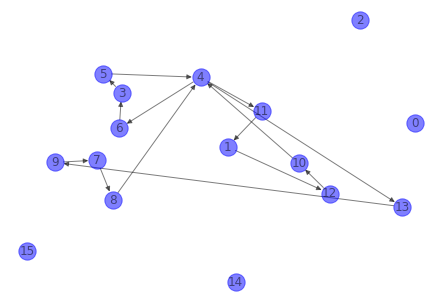

In [105]:
options = {
    'node_color': 'blue',
    'node_size': 300,
    'alpha': 0.5,
    'width': 1,
}

nx.draw(G, pos=pos_t, edgelist=edges, with_labels=True, arrows=True, **options)

## Experimentos

In [151]:
xlsx = pd.ExcelFile('Dados trab PO1.xlsx')
df1 = pd.read_excel(xlsx, 'Pontos Turisticos')
df2 = pd.read_excel(xlsx, 'Recompensa por horario', header=None)
df3 = pd.read_excel(xlsx, 'Custo (reais)', header=None)
df4 = pd.read_excel(xlsx, 'Tempo (min)', header=None)

In [152]:
toy_size = 18
df1 = df1.head(toy_size)
df2 = df2.loc[:toy_size,:]
df3 = df3.loc[:toy_size,:toy_size]
df4 = df4.loc[:toy_size,:toy_size]

In [153]:
startingPoint = 4

df1.at[startingPoint, 'Nome'] = 'Hotel (na praia de Copacabana)'
df1.at[startingPoint,'Abre - horario'] = 9
df1.at[startingPoint,'Fecha - horario'] = 22
df1.at[startingPoint,'Permanecia'] = 0
df1.at[startingPoint,'Custo Fixo'] = 0
df1.at[startingPoint,'Avaliacao'] = 0

In [154]:
CF = np.asarray(df1['Custo Fixo'], dtype=float)       #custo fixo
Ta = np.asarray(df1['Abre - horario'], dtype=float)   #tempo de abertura da janela
Tf = np.asarray(df1['Fecha - horario'], dtype=float)  #tempo de encerramento da janela
Tp = np.asarray(df1['Permanecia'], dtype=float)       #tempo de permanencia em um ponto
RS = np.asarray(df1['Avaliacao'], dtype=float)        #recompensa fixa
RO = np.asarray(df2, dtype=float)                     #recompensa por tempo de chegada
R_max = RS.max() + RO.max()                           #recompensa maxima
C = np.asarray(df3, dtype=float)                      #custo de viagem entre dois pontos
CV_max = C.max()                                      #custo de viagem maximo
CF_max = CF.max()                                     #custo fixo maximo
Td = np.asarray(df4, dtype=float) / 60                #tempo de deslocamento entre dois pontos (em horas)
O = startingPoint                                     #ponto de origem
T_max = float(Tf[O])                                  #horario max de chagada em um ponto
B = 1000000                                           #valor auxiliar
N = len(df1)                                          #quantidade de pontos
D = 3                                                 #quantidade de dias para visita
K = len(df2.columns)                                  #quantidade de janelas de tempo para recompensa (tabela RO)
C_limit = 200                                         #limite de custo

In [159]:
sizes = [6,12] #[6,12,18,25,35]

In [160]:
data = {
    "n_points": [],
    "teste_index": [],
    "days": [],
    "gb_time": [],
    "gb_gap": [],
    "gb_fo": [],
    "cplex_time": [],
    "cplex_gap": [],
    "cplex_fo": [],
    "points": []
}

results_df = pd.DataFrame(data)

In [161]:
for size in sizes:
    for test in range(3) if sizes[0] != 35 else range(1):
        points = list(range(N))
        points.remove(O)
        points = random.sample(points, size - 1)
        points.append(O)
        for days in range(3):
            D = days + 1
            
            #GUROBI
            model = gb.Model("PCTSP_gurobi")

            x = model.addVars(N, N, vtype = gb.GRB.BINARY, name='x')
            y = model.addVars(N, K, vtype = gb.GRB.BINARY, name ='y')
            t = model.addVars(N, vtype = gb.GRB.CONTINUOUS, name ='t')

            t[O] = float(Ta[O])
            for i in range(N):
                x[i,i] = 0

            model.setObjective(gb.quicksum(gb.quicksum(((RO[i,k] + RS[i])/R_max)*y[i,k] for i in points if i != O) for k in range(K)) - gb.quicksum(gb.quicksum((C[i,j]/CV_max + CF[i]/CF_max)*x[i,j] for i in points) for j in points), gb.GRB.MAXIMIZE) 

            #model.addConstr(t[O] >= Ta[O])
            model.addConstrs(x[i,j] <= 1 for i in points for j in points)
            model.addConstrs(gb.quicksum(x[i,j] for j in points) == gb.quicksum(y[i,k] for k in range(K)) for i in points if i != O)
            model.addConstrs(gb.quicksum(x[i,j] for i in points) == gb.quicksum(y[j,k] for k in range(K)) for j in points if j != O)
            model.addConstr(gb.quicksum(x[O,j] for j in points) == D)
            model.addConstr(gb.quicksum(x[i,O] for i in points) == D)
            model.addConstrs(gb.quicksum(y[i,k] for k in range(K)) <= 1 for i in points)
            model.addConstrs(t[i] + Tp[i] + Td[i,O] <= T_max for i in points if i != O)
            model.addConstrs(B - B*gb.quicksum(y[i,k] for k in range(K)) + t[i] >= Ta[i] for i in points)
            model.addConstrs(t[i] + Tp[i] - B + B*gb.quicksum(y[i,k] for k in range(K)) <= Tf[i] for i in points)
            model.addConstrs(t[j] - t[i] - B*x[i,j] >= -B + Td[i,j] + Tp[i] for i in points for j in points if j != O)
            model.addConstrs(t[i] <= B*gb.quicksum(y[i,k] for k in range(K)) for i in points)
            model.addConstrs(t[i] + 0.01 <= gb.quicksum(k*y[i,k] for k in range(K)) + 1 for i in points)
            model.addConstrs(t[i] >= gb.quicksum(k*y[i,k] for k in range(K)) for i in points)
            model.addConstr(gb.quicksum(gb.quicksum(C[i,j]*x[i,j] for i in points) for j in points) + gb.quicksum(CF[i]*gb.quicksum(y[i,k] for k in range(K)) for i in points) <= C_limit)

            model.Params.timeLimit = 30
            model.optimize()
            
            gb_fo = str(round(model.ObjVal,2))
            gb_gap = model.MIPGap * 100
            gb_time = model.Runtime
            
            #CPLEX
            v_x = [(i,j) for i in range(N) for j in range(N)]
            v_y = [(i,k) for i in range(N) for k in range(K)]
            v_t = [i for i in range(N)]

            mdl = CplexModel('PCTSP_cplex')

            x = mdl.binary_var_dict(v_x, name='x')
            y = mdl.binary_var_dict(v_y, name='y')
            t = mdl.continuous_var_dict(v_t, name='t')

            t[O] = Ta[O]
            for i in range(N):
                x[i,i] = 0

            mdl.maximize(mdl.sum(mdl.sum(((RO[i,k] + RS[i])/R_max)*y[(i,k)] for i in points if i != O) for k in range(K)) - mdl.sum(mdl.sum((C[i,j]/CV_max + CF[i]/CF_max)*x[(i,j)] for i in points) for j in points))

            for i in points:
                for j in points:
                    mdl.add_constraint(x[(i,j)] <= 1)

                    if j != O:
                        mdl.add_constraint(t[j] - t[i] - B*x[(i,j)] >= -B + Td[i,j] + Tp[i])

            for i in points:
                mdl.add_constraint(mdl.sum(y[(i,k)] for k in range(K)) <= 1)
                mdl.add_constraint(B - B*mdl.sum(y[(i,k)] for k in range(K)) + t[i] >= Ta[i])
                mdl.add_constraint(t[i] + Tp[i] - B + B*mdl.sum(y[(i,k)] for k in range(K)) <= Tf[i])
                mdl.add_constraint(t[i] <= B*mdl.sum(y[(i,k)] for k in range(K)))
                mdl.add_constraint(t[i] + 0.01 <= mdl.sum(k*y[(i,k)] for k in range(K)) + 1)
                mdl.add_constraint(t[i] >= mdl.sum(k*y[(i,k)] for k in range(K)))

                if i != O:
                    mdl.add_constraint(t[i] + Tp[i] + Td[i,O] <= T_max)
                    mdl.add_constraint(mdl.sum(x[(i,j)] for j in points) == mdl.sum(y[(i,k)] for k in range(K)))
                    mdl.add_constraint(mdl.sum(x[(j,i)] for j in points) == mdl.sum(y[(i,k)] for k in range(K)))

            mdl.add_constraint(mdl.sum(x[(O,j)] for j in points) == D)
            mdl.add_constraint(mdl.sum(x[(i,O)] for i in points) == D)
            mdl.add_constraint(mdl.sum(mdl.sum(C[i,j]*x[(i,j)] for i in points) for j in points) + mdl.sum(CF[i]*mdl.sum(y[i,k] for k in range(K)) for i in points) <= C_limit)

            mdl.parameters.timelimit = 30
            mdl.solve(log_output=False)
            
            cplex_time = mdl.solve_details.time
            cplex_gap = mdl.solve_details.gap
            cplex_fo = mdl.objective_value
            
            #Salvando resultado
            results_df.loc[len(results_df.index)] = [size, test, D, gb_time, gb_gap*100, gb_fo, cplex_time, cplex_gap*100, cplex_fo, points] 

Set parameter TimeLimit to value 30
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 120 rows, 774 columns and 1360 nonzeros
Model fingerprint: 0x87ee6386
Variable types: 18 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [7e-01, 1e+06]
  Objective range  [7e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 58 rows and 697 columns
Presolve time: 0.01s
Presolved: 62 rows, 77 columns, 507 nonzeros
Variable types: 5 continuous, 72 integer (72 binary)
Found heuristic solution: objective 1.2991954

Root relaxation: objective 3.324177e+00, 39 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.32418    0   12    1.29920    3.32418   156%     -    0s
H   

  RHS range        [1e+00, 1e+06]
Presolve removed 58 rows and 690 columns
Presolve time: 0.01s
Presolved: 62 rows, 84 columns, 535 nonzeros
Variable types: 5 continuous, 79 integer (79 binary)
Found heuristic solution: objective 0.0192050

Root relaxation: objective 2.717109e+00, 36 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.71711    0    8    0.01920    2.71711      -     -    0s
     0     0    2.67735    0   10    0.01920    2.67735      -     -    0s
H    0     0                       0.8025383    2.67735   234%     -    0s
     0     0    2.64207    0   16    0.80254    2.64207   229%     -    0s
H    0     0                       2.2100000    2.64207  19.6%     -    0s
     0     0    2.60924    0   14    2.21000    2.60924  18.1%     -    0s
     0     0    2.60883    0   17    2.21000    2.60883  18.0%     -  

     0     0    2.22831    0    6    2.15711    2.22831  3.30%     -    0s
     0     0    2.21847    0   13    2.15711    2.21847  2.84%     -    0s
     0     0    2.20569    0   17    2.15711    2.20569  2.25%     -    0s
     0     0    2.19649    0   14    2.15711    2.19649  1.83%     -    0s
     0     0    2.15926    0    6    2.15711    2.15926  0.10%     -    0s
     0     0     cutoff    0         2.15711    2.15711  0.00%     -    0s

Cutting planes:
  Gomory: 2
  Cover: 2
  Clique: 5
  MIR: 4
  StrongCG: 1
  GUB cover: 3

Explored 1 nodes (253 simplex iterations) in 0.15 seconds (0.02 work units)
Thread count was 4 (of 4 available processors)

Solution count 6: 2.15711 2.0692 1.4467 ... -0.42875

Optimal solution found (tolerance 1.00e-04)
Best objective 2.157112068966e+00, best bound 2.157112068966e+00, gap 0.0000%
Set parameter TimeLimit to value 30
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 

Set parameter TimeLimit to value 30
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 384 rows, 774 columns and 3226 nonzeros
Model fingerprint: 0x1a36b6df
Variable types: 18 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+06]
  Objective range  [5e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 183 rows and 527 columns
Presolve time: 0.02s
Presolved: 201 rows, 247 columns, 1271 nonzeros
Variable types: 11 continuous, 236 integer (236 binary)
Found heuristic solution: objective 1.9071552

Root relaxation: objective 7.678985e+00, 67 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    7.67899    0   21    1.90716    7.67899   303%     -    

Thread count was 4 (of 4 available processors)

Solution count 10: 6.01174 5.95507 5.84799 ... 2.32716

Optimal solution found (tolerance 1.00e-04)
Best objective 6.011738505747e+00, best bound 6.011738505747e+00, gap 0.0000%
Set parameter TimeLimit to value 30
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 384 rows, 774 columns and 3274 nonzeros
Model fingerprint: 0x8daefe44
Variable types: 18 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+06]
  Objective range  [5e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Found heuristic solution: objective 0.1537500
Presolve removed 183 rows and 535 columns
Presolve time: 0.02s
Presolved: 201 rows, 239 columns, 1296 nonzeros
Variable types: 11 continuous, 228 integer (228 binary)

Root relaxation: objective 6.623928e+00, 77 iterations, 0.00 seconds (0.00 work units

H 3430  1010                       3.2533621    4.97956  53.1%  21.0    2s
  7960  2283    3.91781   30   31    3.25336    4.62702  42.2%  21.3    5s
 20851  4292 infeasible   37         3.25336    4.21721  29.6%  20.9   11s
*31793  4471              41       3.2562787    3.97487  22.1%  20.4   14s
 32663  4403    3.46259   31   22    3.25628    3.95095  21.3%  20.3   15s

Cutting planes:
  Learned: 10
  Gomory: 17
  Cover: 247
  Implied bound: 7
  Projected implied bound: 1
  Clique: 1
  MIR: 18
  StrongCG: 3
  Flow cover: 16
  GUB cover: 65
  Inf proof: 2
  Zero half: 27
  RLT: 14
  Relax-and-lift: 3

Explored 51701 nodes (972517 simplex iterations) in 19.81 seconds (15.30 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 3.25628 3.25336 3.2467 ... 2.31173

Optimal solution found (tolerance 1.00e-04)
Best objective 3.256278735632e+00, best bound 3.256278735632e+00, gap 0.0000%
Set parameter TimeLimit to value 30
Gurobi Optimizer version 9.5.1 build v9.5.1


Explored 39207 nodes (1201412 simplex iterations) in 29.93 seconds (18.02 work units)
Thread count was 4 (of 4 available processors)

Solution count 7: 3.06545 3.02378 2.94045 ... 0.49

Optimal solution found (tolerance 1.00e-04)
Best objective 3.065445402299e+00, best bound 3.065445402299e+00, gap 0.0000%
Set parameter TimeLimit to value 30
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 384 rows, 774 columns and 3274 nonzeros
Model fingerprint: 0xe6e2c34a
Variable types: 18 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+06]
  Objective range  [5e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 183 rows and 529 columns
Presolve time: 0.02s
Presolved: 201 rows, 245 columns, 1248 nonzeros
Variable types: 11 continuous, 234 integer (234 binary)
Found heuristic solution: objective -0.2750000

R

H   72    70                       5.0830172    5.88837  15.8%  12.2    0s
H  268   121                       5.6176006    5.84427  4.03%  11.3    0s

Cutting planes:
  Learned: 5
  Gomory: 2
  Cover: 11
  Implied bound: 3
  MIR: 10
  StrongCG: 1
  GUB cover: 27
  Zero half: 3
  RLT: 10
  Relax-and-lift: 1

Explored 575 nodes (6540 simplex iterations) in 0.64 seconds (0.21 work units)
Thread count was 4 (of 4 available processors)

Solution count 7: 5.6176 5.08302 4.7076 ... 2.07257

Optimal solution found (tolerance 1.00e-04)
Best objective 5.617600574713e+00, best bound 5.617600574713e+00, gap 0.0000%


In [162]:
round(results_df,2)

,n_points,teste_index,days,gb_time,gb_gap,gb_fo,cplex_time,cplex_gap,cplex_fo
0,6.0,0.0,1.0,0.23,0.00,2.17,0.14,0.00,2.17
1,6.0,0.0,2.0,0.18,0.00,2.78,0.03,0.00,2.78
2,6.0,0.0,3.0,0.14,0.00,2.62,0.02,0.00,2.62
3,6.0,1.0,1.0,0.14,0.00,2.27,0.14,0.01,2.27
4,6.0,1.0,2.0,0.12,0.00,2.32,0.05,0.00,2.32
5,6.0,1.0,3.0,0.09,0.00,2.28,0.03,0.00,2.28
6,6.0,2.0,1.0,0.16,0.00,2.16,0.05,0.00,2.16
7,6.0,2.0,2.0,0.11,0.00,2.08,0.03,0.00,2.08
8,6.0,2.0,3.0,0.05,0.00,1.91,0.00,0.00,1.91
9,12.0,0.0,1.0,30.03,6440.90,3.52,30.02,84.60,3.28
